In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from calendar import month_abbr
from datetime import datetime

customers = pd.read_csv('data/Customers.csv')
products = pd.read_csv('data/Products.csv')
transactions = pd.read_csv('data/Transactions.csv')

<h3>Insight 1 - Customer and Product performance</h3>


Key Insights:
Average Monthly Spending: $865.69
Max Customer Tenure: 1061 days
Average Lifetime Value: $3467.31
Top Region: South America
Customers by Region: {'Asia': 44, 'Europe': 50, 'North America': 46, 'South America': 59}
Average Transaction Value: $690.00


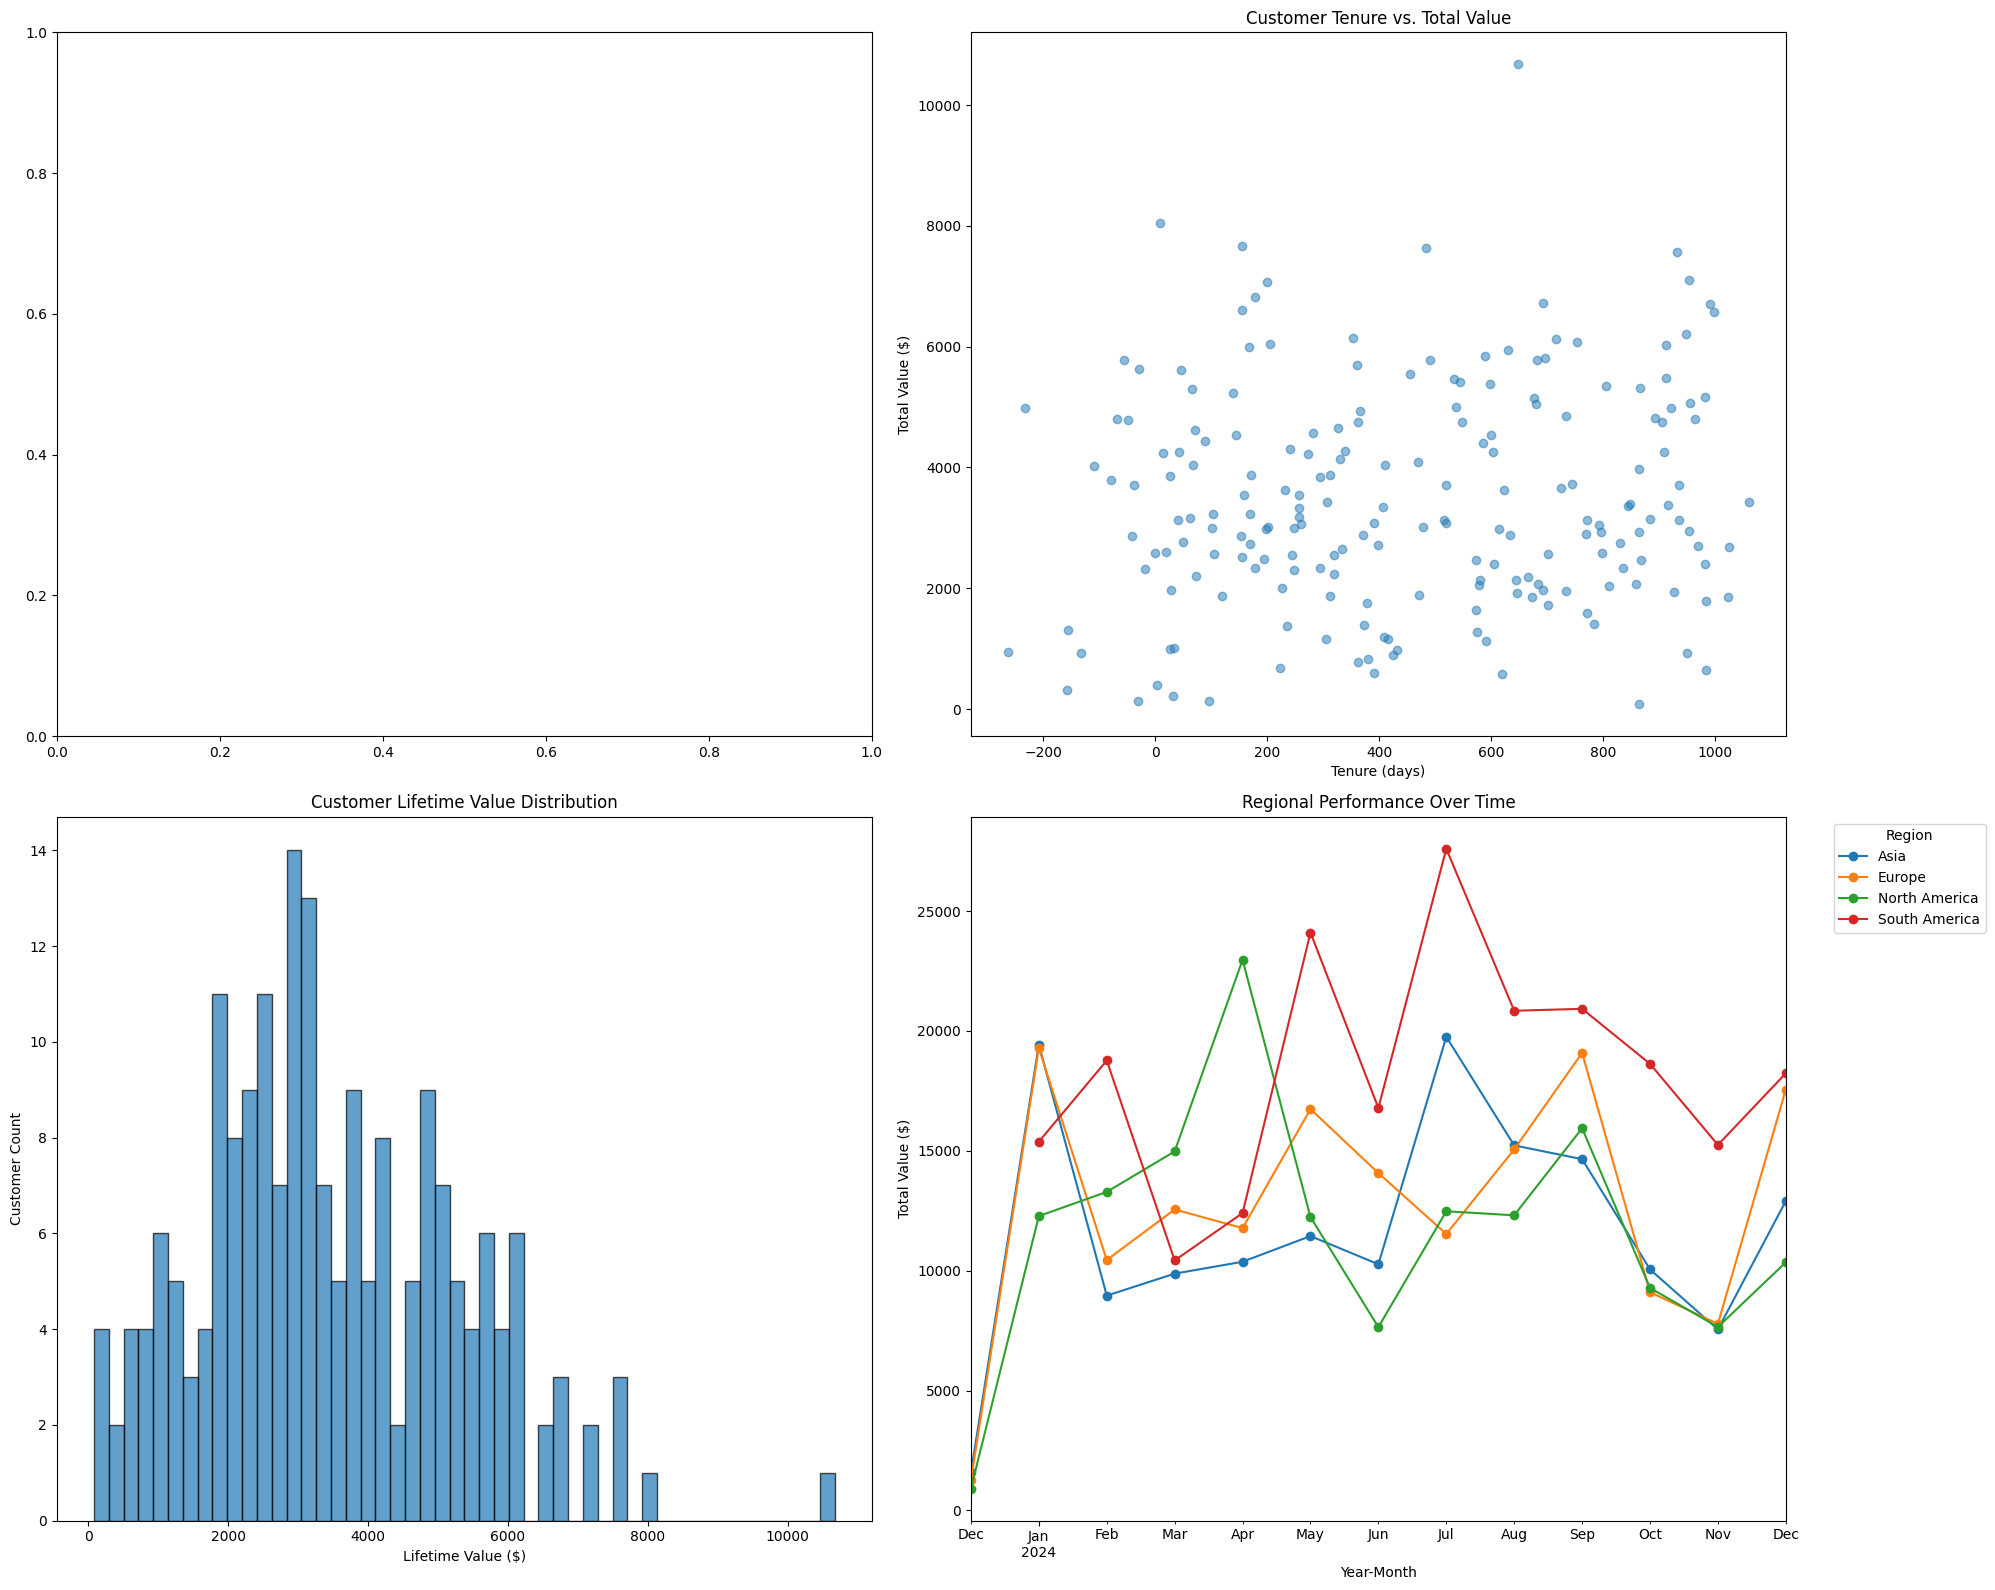

In [18]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

data = pd.merge(transactions, customers, on='CustomerID')

data['CustomerTenure'] = (data['TransactionDate'] - data['SignupDate']).dt.days

def analyze_customer_tenure():
    metrics = data.groupby('CustomerID').agg({
        'CustomerTenure': 'max',
        'TotalValue': 'sum',
        'TransactionID': 'count'
    }).reset_index()
    metrics['AvgMonthlyValue'] = metrics['TotalValue'] / (metrics['CustomerTenure'] / 30)
    return metrics

def analyze_regional_performance():
    data['YearMonth'] = data['TransactionDate'].dt.to_period('M')
    performance = data.groupby(['Region', 'YearMonth']).agg({
        'TotalValue': 'sum',
        'CustomerID': 'nunique'
    }).reset_index()
    return performance

def create_visualizations(monthly_spending, customer_metrics, regional_performance):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    axes[0, 1].scatter(customer_metrics['CustomerTenure'], customer_metrics['TotalValue'], alpha=0.5)
    axes[0, 1].set_title('Customer Tenure vs. Total Value')
    axes[0, 1].set_xlabel('Tenure (days)')
    axes[0, 1].set_ylabel('Total Value ($)')

    axes[1, 0].hist(customer_metrics['TotalValue'], bins=50, alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Customer Lifetime Value Distribution')
    axes[1, 0].set_xlabel('Lifetime Value ($)')
    axes[1, 0].set_ylabel('Customer Count')

    pivot = regional_performance.pivot(index='YearMonth', columns='Region', values='TotalValue')
    pivot.plot(ax=axes[1, 1], marker='o')
    axes[1, 1].set_title('Regional Performance Over Time')
    axes[1, 1].set_xlabel('Year-Month')
    axes[1, 1].set_ylabel('Total Value ($)')
    axes[1, 1].legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    return fig

def calculate_insights(monthly_spending, customer_metrics, regional_performance):
    insights = {
        'Average Monthly Spending': f"${monthly_spending['mean'].mean():.2f}",
        'Max Customer Tenure': f"{customer_metrics['CustomerTenure'].max()} days",
        'Average Lifetime Value': f"${customer_metrics['TotalValue'].mean():.2f}",
        'Top Region': regional_performance.groupby('Region')['TotalValue'].sum().idxmax(),
        'Customers by Region': data.groupby('Region')['CustomerID'].nunique().to_dict(),
        'Average Transaction Value': f"${data['TotalValue'].mean():.2f}"
    }
    return insights

customer_metrics = analyze_customer_tenure()
regional_performance = analyze_regional_performance()
fig = create_visualizations(monthly_spending, customer_metrics, regional_performance)
insights = calculate_insights(monthly_spending, customer_metrics, regional_performance)

print("\nKey Insights:")
for key, value in insights.items():
    print(f"{key}: {value}")


<h3>Insight 2 - Most Sold category of Product by Region</h3>

C:\Users\rajuk\AppData\Local\Temp\ipykernel_1212\1629486814.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(3, 'Percentage')['Category'].tolist())



Key Business Insights:

1. Top Performing Categories by Region:
Asia: Clothing ($49,353.09)
Europe: Books ($47,464.42)
North America: Electronics ($44,716.43)
South America: Books ($69,752.03)

2. Most Consistent Category (Lowest Sales Variance): Home Decor

3. Highest Growth Category: Electronics

4. Top 3 Categories by Region (% of Sales):
Asia: Clothing, Electronics, Home Decor
Europe: Books, Electronics, Home Decor
North America: Electronics, Books, Clothing
South America: Books, Electronics, Home Decor


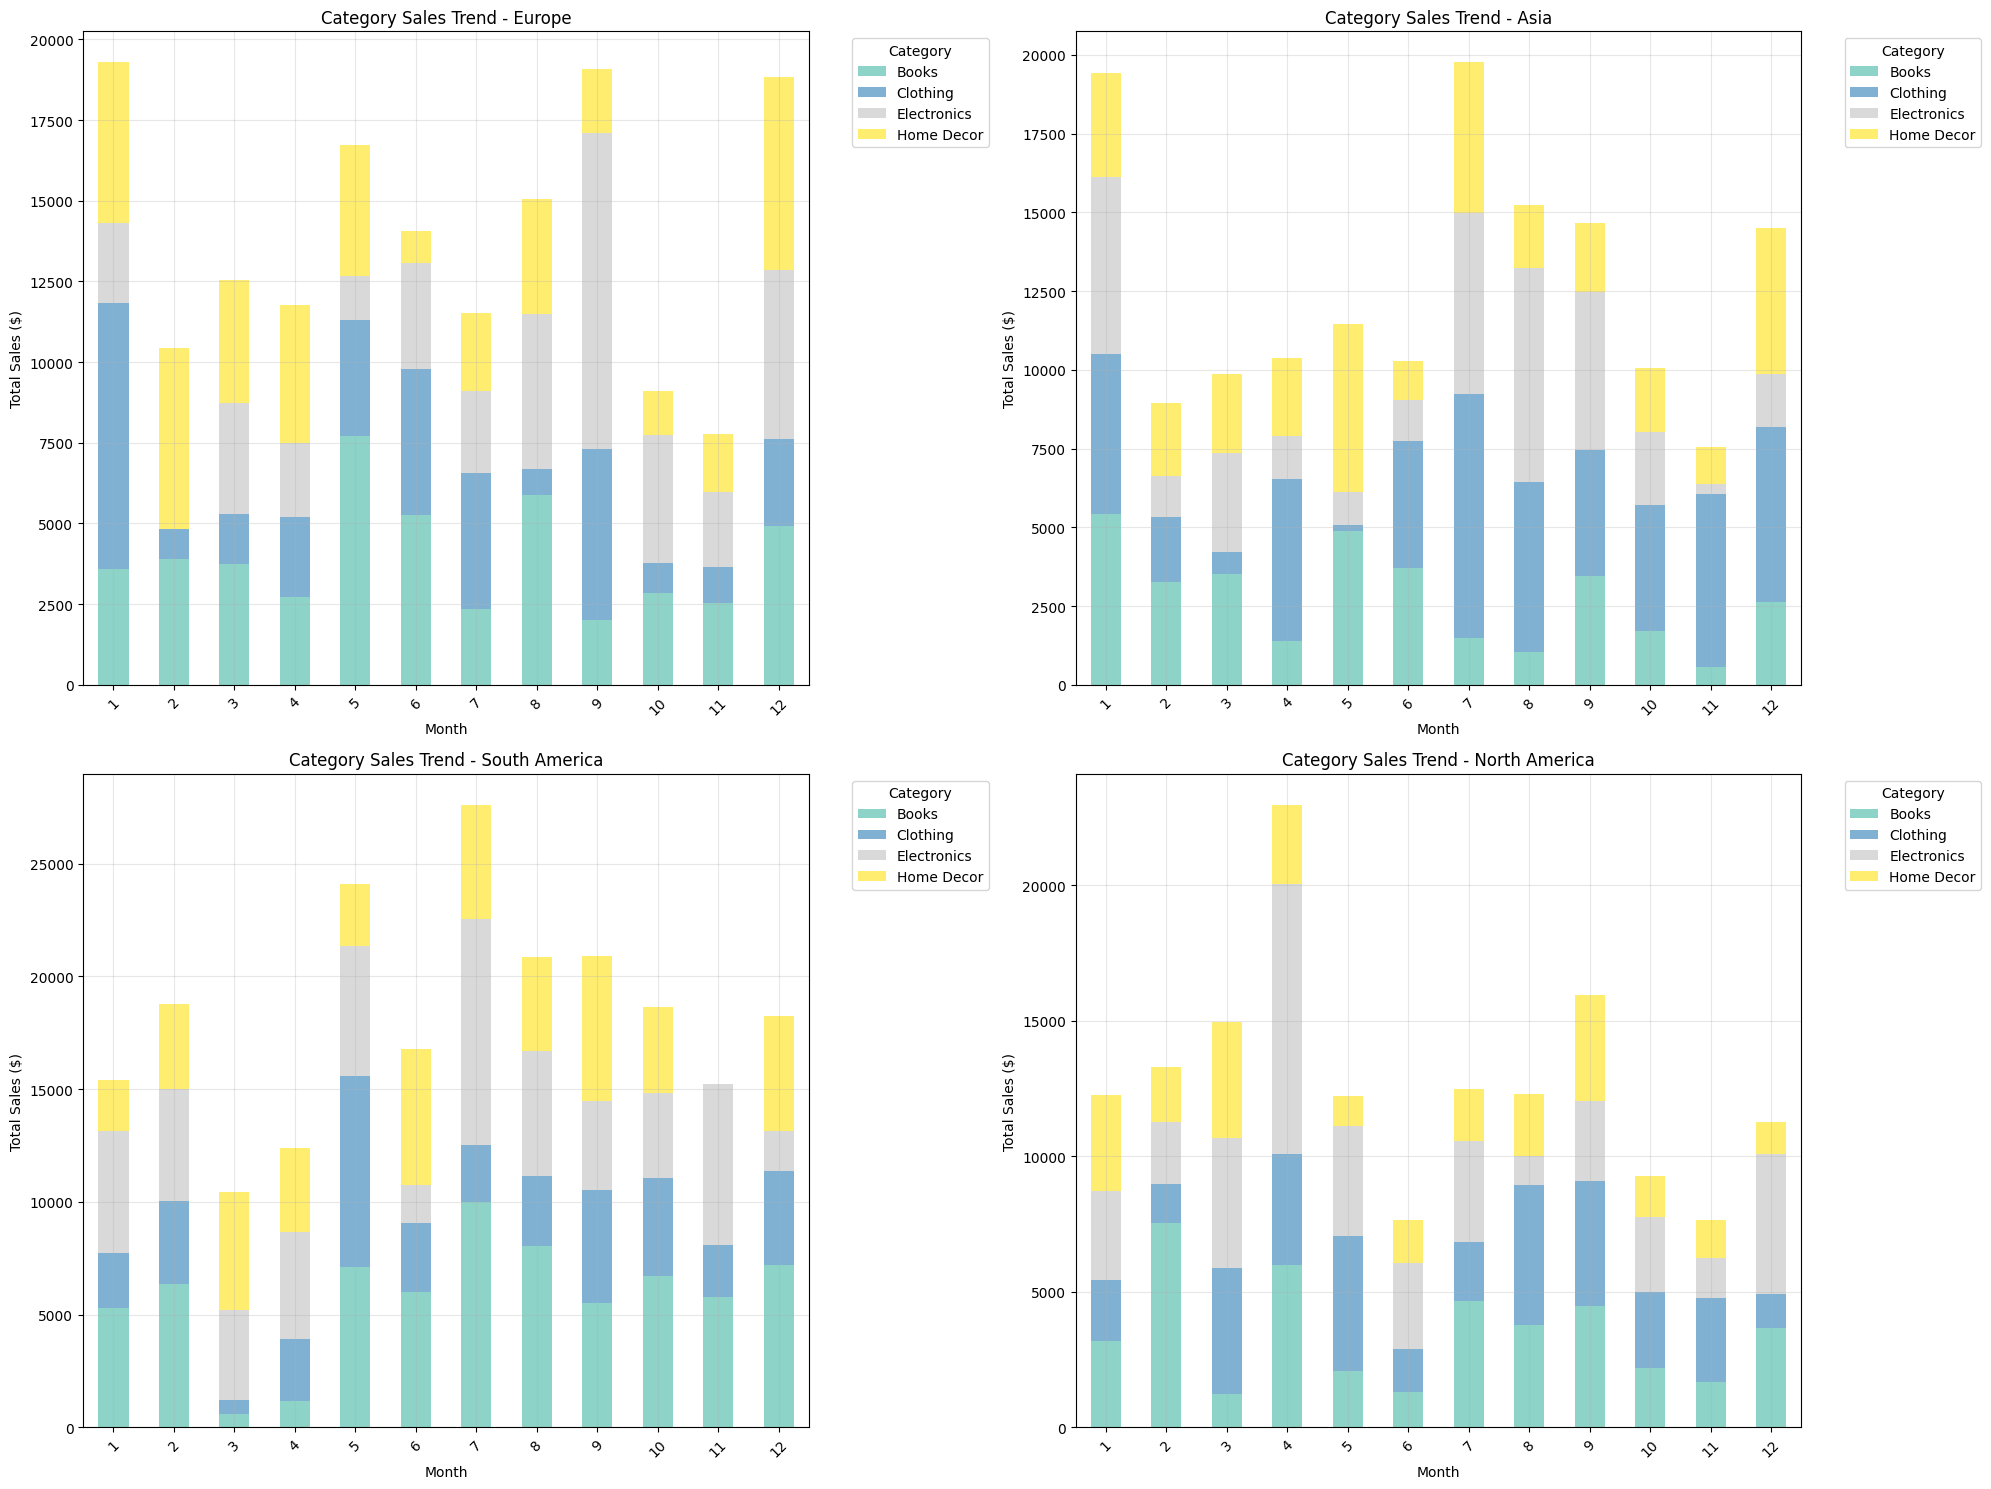

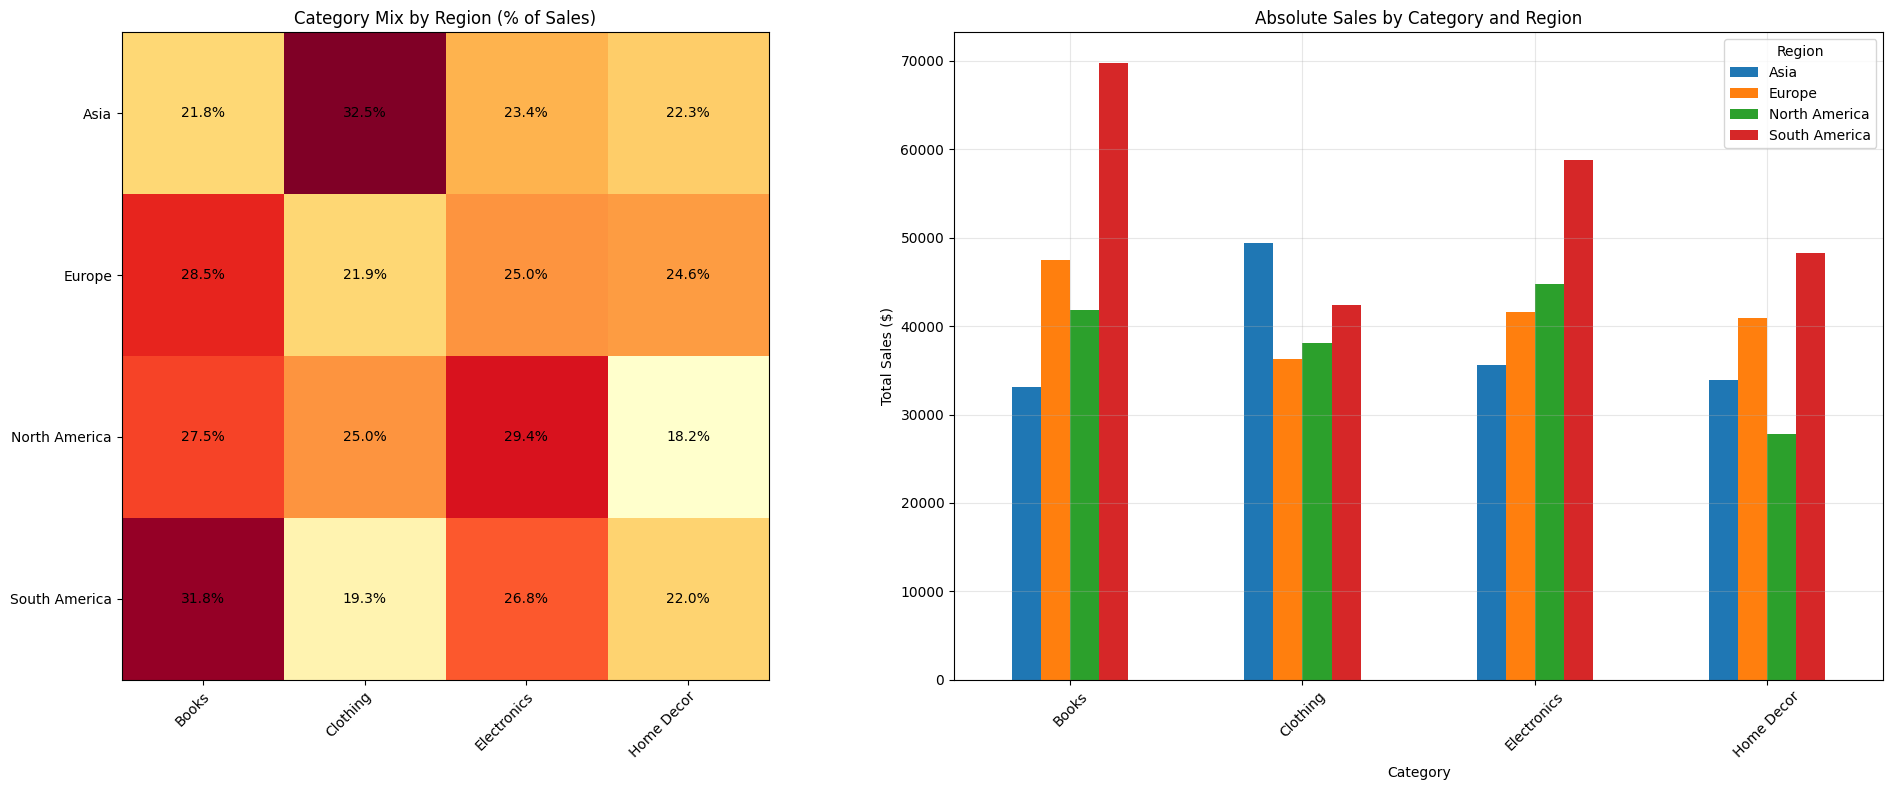

In [20]:
df = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['Month'] = df['TransactionDate'].dt.month
df['MonthName'] = df['TransactionDate'].dt.strftime('%b')

def create_category_analysis():
    monthly_category = df.groupby(['Region', 'Month', 'Category']).agg({
        'TotalValue': 'sum',
        'TransactionID': 'count'
    }).reset_index()
    
    monthly_category['MonthName'] = monthly_category['Month'].map(lambda x: month_abbr[x])
    
    category_mix = df.groupby(['Region', 'Category']).agg({
        'TotalValue': 'sum',
        'Quantity': 'sum'
    }).reset_index()
    
    total_by_region = category_mix.groupby('Region')['TotalValue'].sum().reset_index()
    category_mix = category_mix.merge(total_by_region, on='Region', suffixes=('', '_total'))
    category_mix['Percentage'] = (category_mix['TotalValue'] / category_mix['TotalValue_total'] * 100)
    
    return monthly_category, category_mix

def create_visualizations(monthly_category, category_mix):
    fig = plt.figure(figsize=(20, 15))
    ax1 = plt.subplot(221)
    regions = df['Region'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(df['Category'].unique())))
    
    for idx, region in enumerate(regions):
        region_data = monthly_category[monthly_category['Region'] == region]
        pivot_data = region_data.pivot(index='Month', columns='Category', values='TotalValue')
        ax = plt.subplot(2, 2, idx+1)
        pivot_data.plot(kind='bar', stacked=True, ax=ax, color=colors)
        ax.set_title(f'Category Sales Trend - {region}')
        ax.set_xlabel('Month')
        ax.set_ylabel('Total Sales ($)')
        ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    fig2, ax2 = plt.subplots(1, 2, figsize=(20, 8))
    pivot_heatmap = category_mix.pivot(index='Region', columns='Category', values='Percentage')
    im = ax2[0].imshow(pivot_heatmap, cmap='YlOrRd')
    
    for i in range(len(pivot_heatmap.index)):
        for j in range(len(pivot_heatmap.columns)):
            text = ax2[0].text(j, i, f'{pivot_heatmap.iloc[i, j]:.1f}%',
                           ha="center", va="center", color="black")
    
    ax2[0].set_xticks(np.arange(len(pivot_heatmap.columns)))
    ax2[0].set_yticks(np.arange(len(pivot_heatmap.index)))
    ax2[0].set_xticklabels(pivot_heatmap.columns)
    ax2[0].set_yticklabels(pivot_heatmap.index)
    plt.setp(ax2[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax2[0].set_title('Category Mix by Region (% of Sales)')
    
    category_mix_pivot = category_mix.pivot(index='Category', columns='Region', values='TotalValue')
    category_mix_pivot.plot(kind='bar', ax=ax2[1])
    ax2[1].set_title('Absolute Sales by Category and Region')
    ax2[1].set_xlabel('Category')
    ax2[1].set_ylabel('Total Sales ($)')
    ax2[1].legend(title='Region')
    ax2[1].grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    return fig, fig2

def calculate_insights(monthly_category, category_mix):
    insights = {
        'Top Category by Region': category_mix.sort_values('TotalValue', ascending=False)
                                .groupby('Region').first()[['Category', 'TotalValue']]
                                .to_dict('index'),
        'Most Consistent Category': monthly_category.groupby('Category')['TotalValue']
                                  .std().idxmin(),
        'Highest Growth Category': monthly_category.groupby(['Category', 'Month'])['TotalValue']
                                 .sum().reset_index()
                                 .sort_values('TotalValue', ascending=False)['Category'].iloc[0],
        'Regional Category Mix': category_mix.groupby('Region')
                               .apply(lambda x: x.nlargest(3, 'Percentage')['Category'].tolist())
                               .to_dict()
    }
    return insights

monthly_category, category_mix = create_category_analysis()
fig1, fig2 = create_visualizations(monthly_category, category_mix)
insights = calculate_insights(monthly_category, category_mix)

print("\nKey Business Insights:")
print("\n1. Top Performing Categories by Region:")
for region, data in insights['Top Category by Region'].items():
    print(f"{region}: {data['Category']} (${data['TotalValue']:,.2f})")

print(f"\n2. Most Consistent Category (Lowest Sales Variance): {insights['Most Consistent Category']}")
print(f"\n3. Highest Growth Category: {insights['Highest Growth Category']}")

print("\n4. Top 3 Categories by Region (% of Sales):")
for region, categories in insights['Regional Category Mix'].items():
    print(f"{region}: {', '.join(categories)}")

<h3>Insight 3 - Shopping Hour Pattern by Customers in Different Region</h3>

C:\Users\rajuk\AppData\Local\Temp\ipykernel_1212\52617992.py:132: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x['TransactionID'].idxmax(), 'Hour'])



Key Shopping Pattern Insights:

1. Overall Peak Shopping Hour: 14:00

2. Busiest Shopping Day: Tuesday

3. Peak Shopping Hours by Region:
   Asia: 3:00
   Europe: 16:00
   North America: 1:00
   South America: 14:00

4. Hour with Highest Average Transaction Value: 16:00

5. Peak Shopping Month by Region:
   Asia: ('Asia', 'Jan')
   Europe: ('Europe', 'Jan')
   North America: ('North America', 'Apr')
   South America: ('South America', 'Jul')


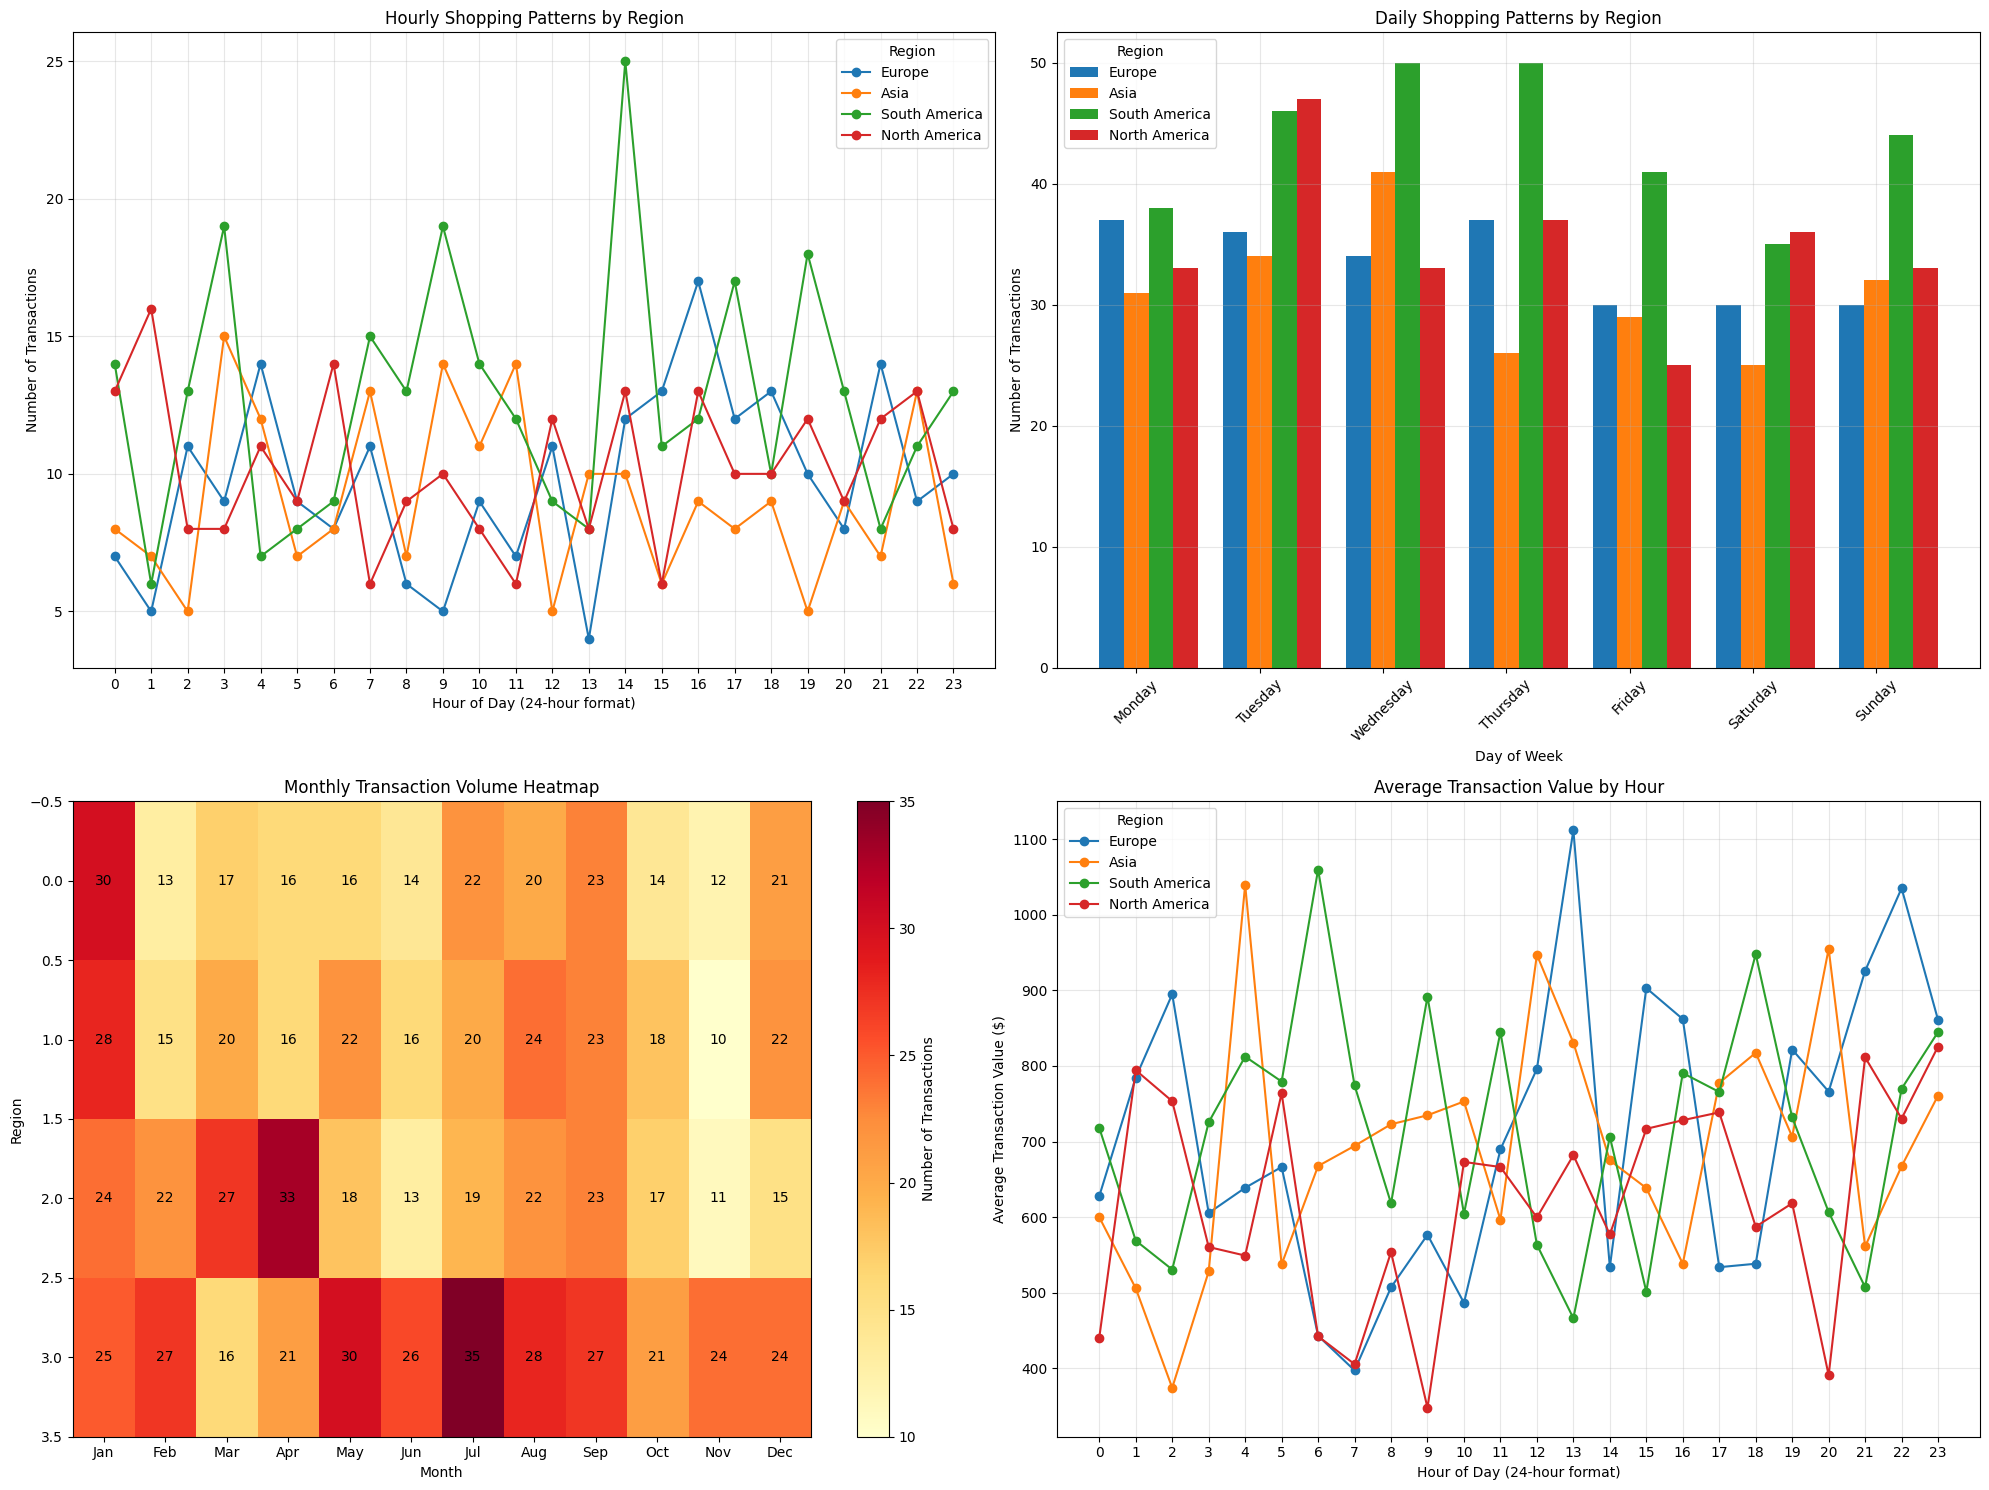

In [6]:
df = transactions.merge(customers, on='CustomerID')

df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

df['Hour'] = df['TransactionDate'].dt.hour
df['DayOfWeek'] = df['TransactionDate'].dt.dayofweek
df['Month'] = df['TransactionDate'].dt.month
df['Year'] = df['TransactionDate'].dt.year
df['DayName'] = df['TransactionDate'].dt.day_name()
df['MonthName'] = df['TransactionDate'].dt.strftime('%b')

def analyze_shopping_patterns():
    # Hourly patterns by region
    hourly_patterns = df.groupby(['Region', 'Hour']).agg({
        'TransactionID': 'count',
        'TotalValue': 'sum'
    }).reset_index()
    
    # Daily patterns by region
    daily_patterns = df.groupby(['Region', 'DayOfWeek', 'DayName']).agg({
        'TransactionID': 'count',
        'TotalValue': 'sum'
    }).reset_index()
    
    # Monthly patterns by region
    monthly_patterns = df.groupby(['Region', 'Month', 'MonthName']).agg({
        'TransactionID': 'count',
        'TotalValue': 'sum'
    }).reset_index()
    
    return hourly_patterns, daily_patterns, monthly_patterns

def create_visualizations(hourly_patterns, daily_patterns, monthly_patterns):
    plt.style.use('default')
    
    fig = plt.figure(figsize=(20, 15))
    
    ax1 = plt.subplot(221)
    for region in df['Region'].unique():
        region_data = hourly_patterns[hourly_patterns['Region'] == region]
        ax1.plot(region_data['Hour'], 
                region_data['TransactionID'],
                marker='o',
                label=region)
    
    ax1.set_title('Hourly Shopping Patterns by Region')
    ax1.set_xlabel('Hour of Day (24-hour format)')
    ax1.set_ylabel('Number of Transactions')
    ax1.grid(True, alpha=0.3)
    ax1.legend(title='Region')
    ax1.set_xticks(range(0, 24))
    ax2 = plt.subplot(222)
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    width = 0.8 / len(df['Region'].unique())
    
    for idx, region in enumerate(df['Region'].unique()):
        region_data = daily_patterns[daily_patterns['Region'] == region]
        x = np.arange(len(days)) + idx * width
        ax2.bar(x, region_data['TransactionID'], width, label=region)
    
    ax2.set_title('Daily Shopping Patterns by Region')
    ax2.set_xlabel('Day of Week')
    ax2.set_ylabel('Number of Transactions')
    ax2.set_xticks(np.arange(len(days)) + width)
    ax2.set_xticklabels(days, rotation=45)
    ax2.grid(True, alpha=0.3)
    ax2.legend(title='Region')
    
    ax3 = plt.subplot(223)
    pivot_monthly = monthly_patterns.pivot(index='Region', 
                                         columns='Month', 
                                         values='TransactionID')
    im = ax3.imshow(pivot_monthly, aspect='auto', cmap='YlOrRd')
    
    for i in range(len(pivot_monthly.index)):
        for j in range(len(pivot_monthly.columns)):
            text = ax3.text(j, i, f'{pivot_monthly.iloc[i, j]:.0f}',
                          ha="center", va="center", color="black")
    
    ax3.set_title('Monthly Transaction Volume Heatmap')
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Region')
    ax3.set_xticks(range(12))
    ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.colorbar(im, ax=ax3, label='Number of Transactions')
    
    ax4 = plt.subplot(224)
    for region in df['Region'].unique():
        region_data = hourly_patterns[hourly_patterns['Region'] == region]
        avg_value = region_data['TotalValue'] / region_data['TransactionID']
        ax4.plot(region_data['Hour'], 
                avg_value,
                marker='o',
                label=region)
    
    ax4.set_title('Average Transaction Value by Hour')
    ax4.set_xlabel('Hour of Day (24-hour format)')
    ax4.set_ylabel('Average Transaction Value ($)')
    ax4.grid(True, alpha=0.3)
    ax4.legend(title='Region')
    ax4.set_xticks(range(0, 24))
    
    plt.tight_layout()
    return fig

def calculate_insights(hourly_patterns, daily_patterns, monthly_patterns):
    insights = {
        'Peak Hours': hourly_patterns.groupby('Hour')['TransactionID'].sum().idxmax(),
        'Busiest Day': daily_patterns.groupby('DayName')['TransactionID'].sum().idxmax(),
        'Regional Peak Hours': hourly_patterns.groupby(['Region'])
                             .apply(lambda x: x.loc[x['TransactionID'].idxmax(), 'Hour'])
                             .to_dict(),
        'Highest Value Hours': hourly_patterns.groupby('Hour')
                             ['TotalValue'].mean().idxmax(),
        'Monthly Peaks': monthly_patterns.groupby(['Region', 'MonthName'])
                        ['TransactionID'].sum().groupby('Region').idxmax().to_dict()
    }
    return insights


hourly_patterns, daily_patterns, monthly_patterns = analyze_shopping_patterns()
fig = create_visualizations(hourly_patterns, daily_patterns, monthly_patterns)
insights = calculate_insights(hourly_patterns, daily_patterns, monthly_patterns)

print("\nKey Shopping Pattern Insights:")
print(f"\n1. Overall Peak Shopping Hour: {insights['Peak Hours']}:00")
print(f"\n2. Busiest Shopping Day: {insights['Busiest Day']}")
print("\n3. Peak Shopping Hours by Region:")
for region, hour in insights['Regional Peak Hours'].items():
    print(f"   {region}: {hour}:00")
print(f"\n4. Hour with Highest Average Transaction Value: {insights['Highest Value Hours']}:00")
print("\n5. Peak Shopping Month by Region:")
for region, month in insights['Monthly Peaks'].items():
    print(f"   {region}: {month}")

<h3>Insight 4 - Top sold Products in Different Category</h3>


Key Product Performance Insights:

1. Top 5 Products Overall (by Quantity):
1. ActiveWear Textbook (Books)
   Quantity: 38, Revenue: $11,296.11
2. ActiveWear Smartwatch (Electronics)
   Quantity: 38, Revenue: $14,226.61
3. SoundWave Headphones (Electronics)
   Quantity: 37, Revenue: $9,479.35
4. ActiveWear Rug (Home Decor)
   Quantity: 30, Revenue: $7,488.25
5. HomeSense Desk Lamp (Home Decor)
   Quantity: 29, Revenue: $5,731.14

2. Category Leaders:

Electronics:
Top Product: ActiveWear Smartwatch
Quantity Sold: 38
Revenue Generated: $14,226.61

Clothing:
Top Product: HomeSense T-Shirt
Quantity Sold: 28
Revenue Generated: $3,857.04

Books:
Top Product: ActiveWear Textbook
Quantity Sold: 38
Revenue Generated: $11,296.11

Home Decor:
Top Product: ActiveWear Rug
Quantity Sold: 30
Revenue Generated: $7,488.25

3. Regional Winners:

Europe:
Top Product: ActiveWear Rug (Home Decor)
Quantity Sold: 30
Revenue Generated: $7,488.25

Asia:
Top Product: HomeSense T-Shirt (Clothing)
Quantity Sold

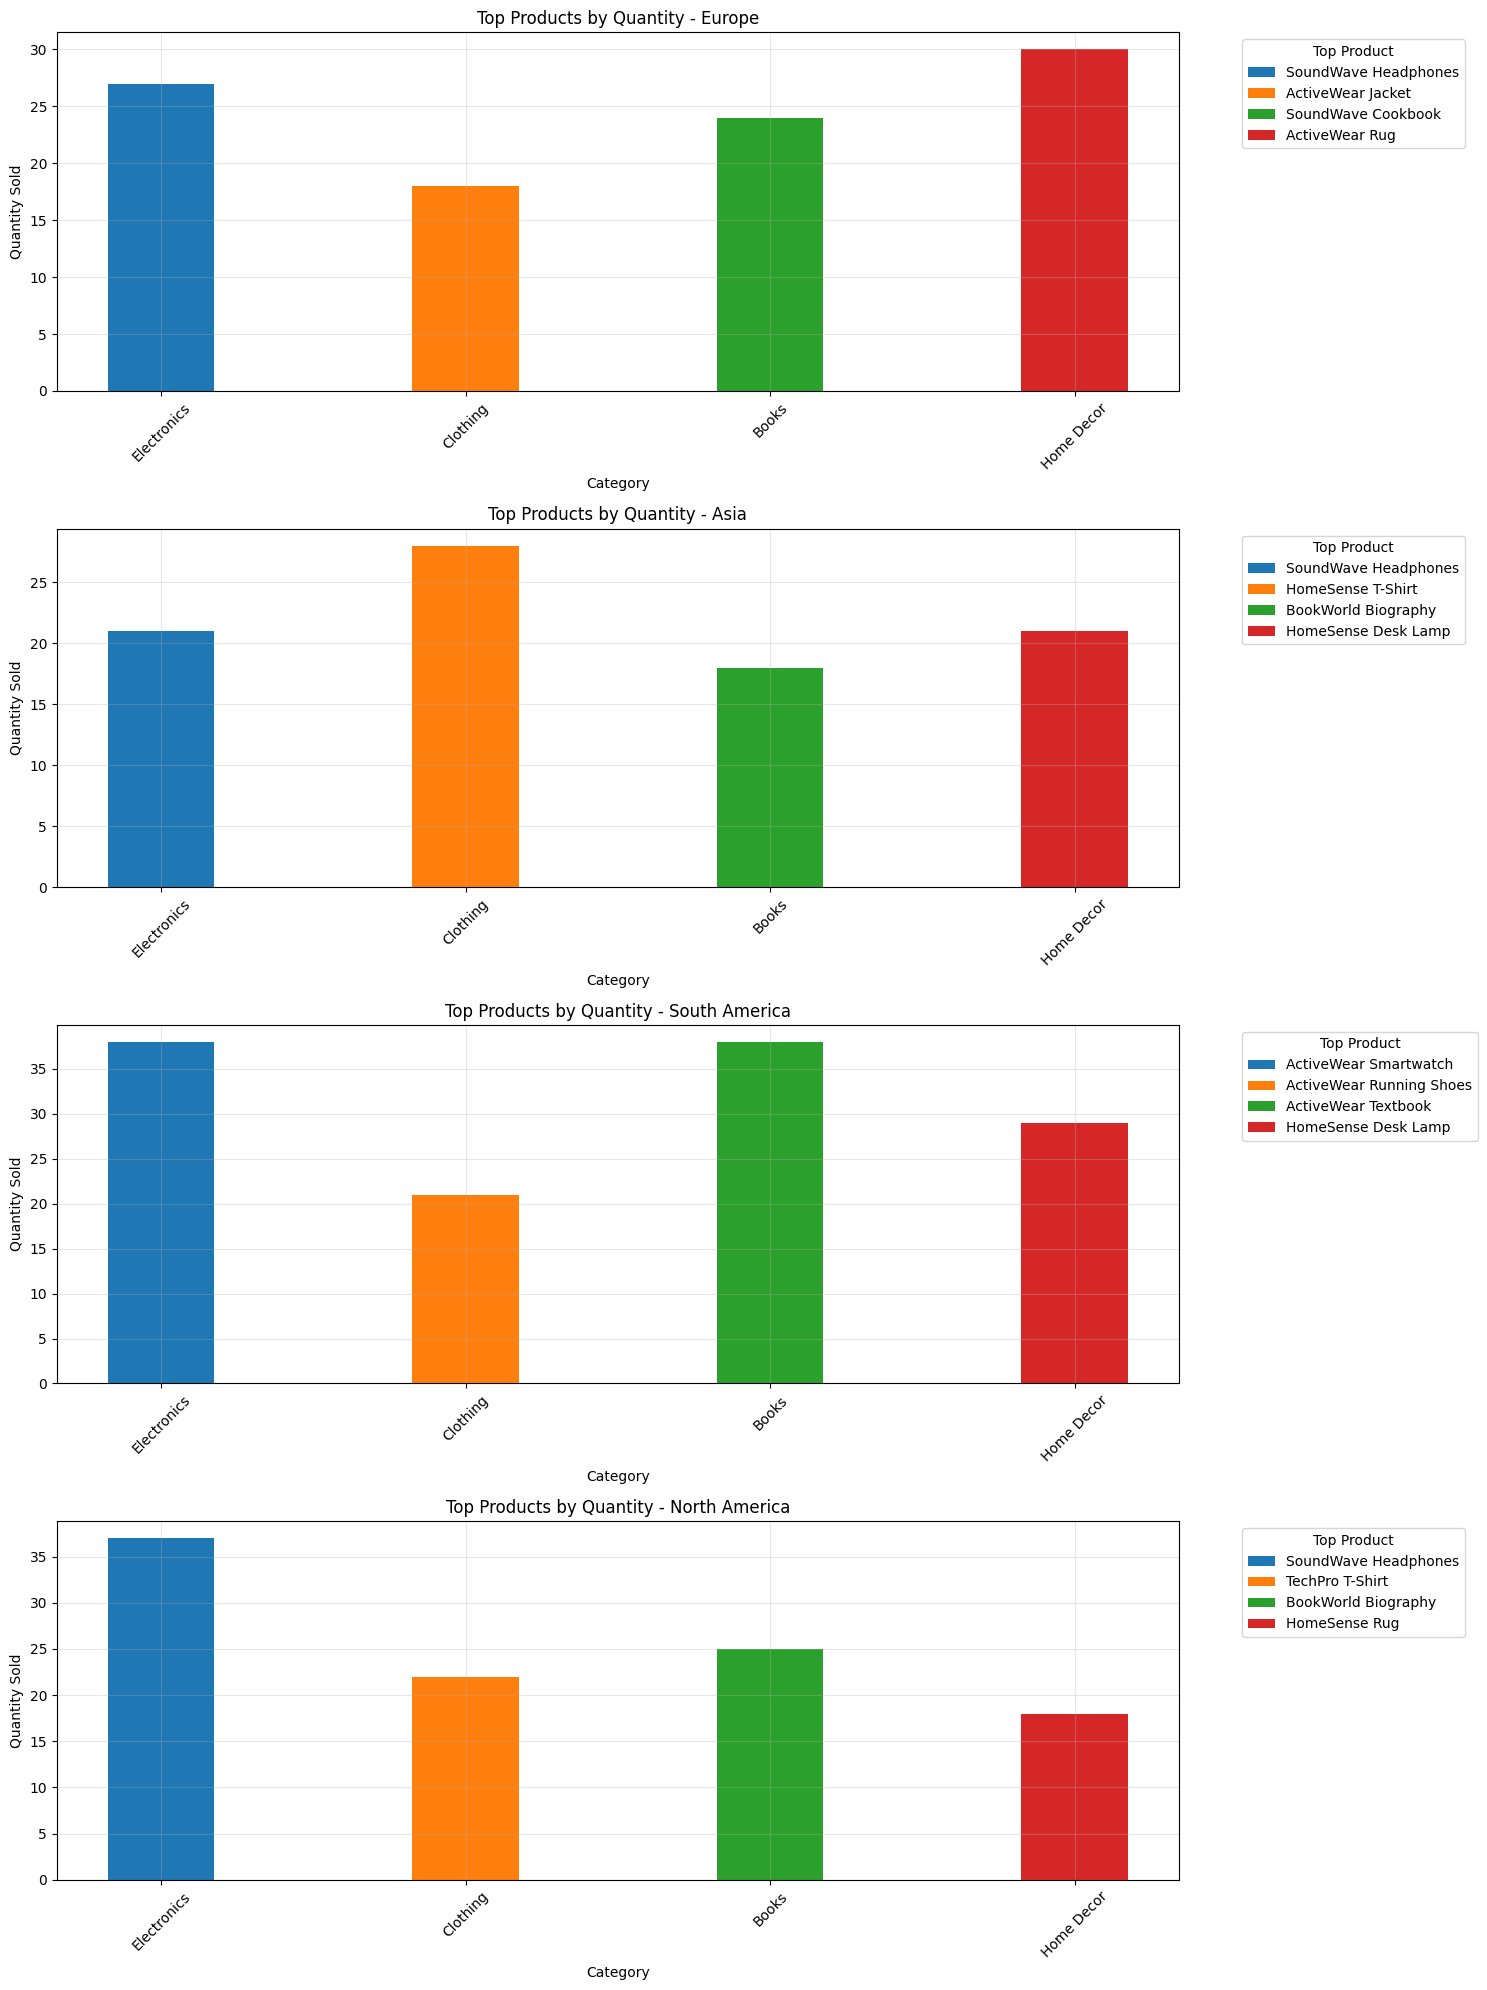

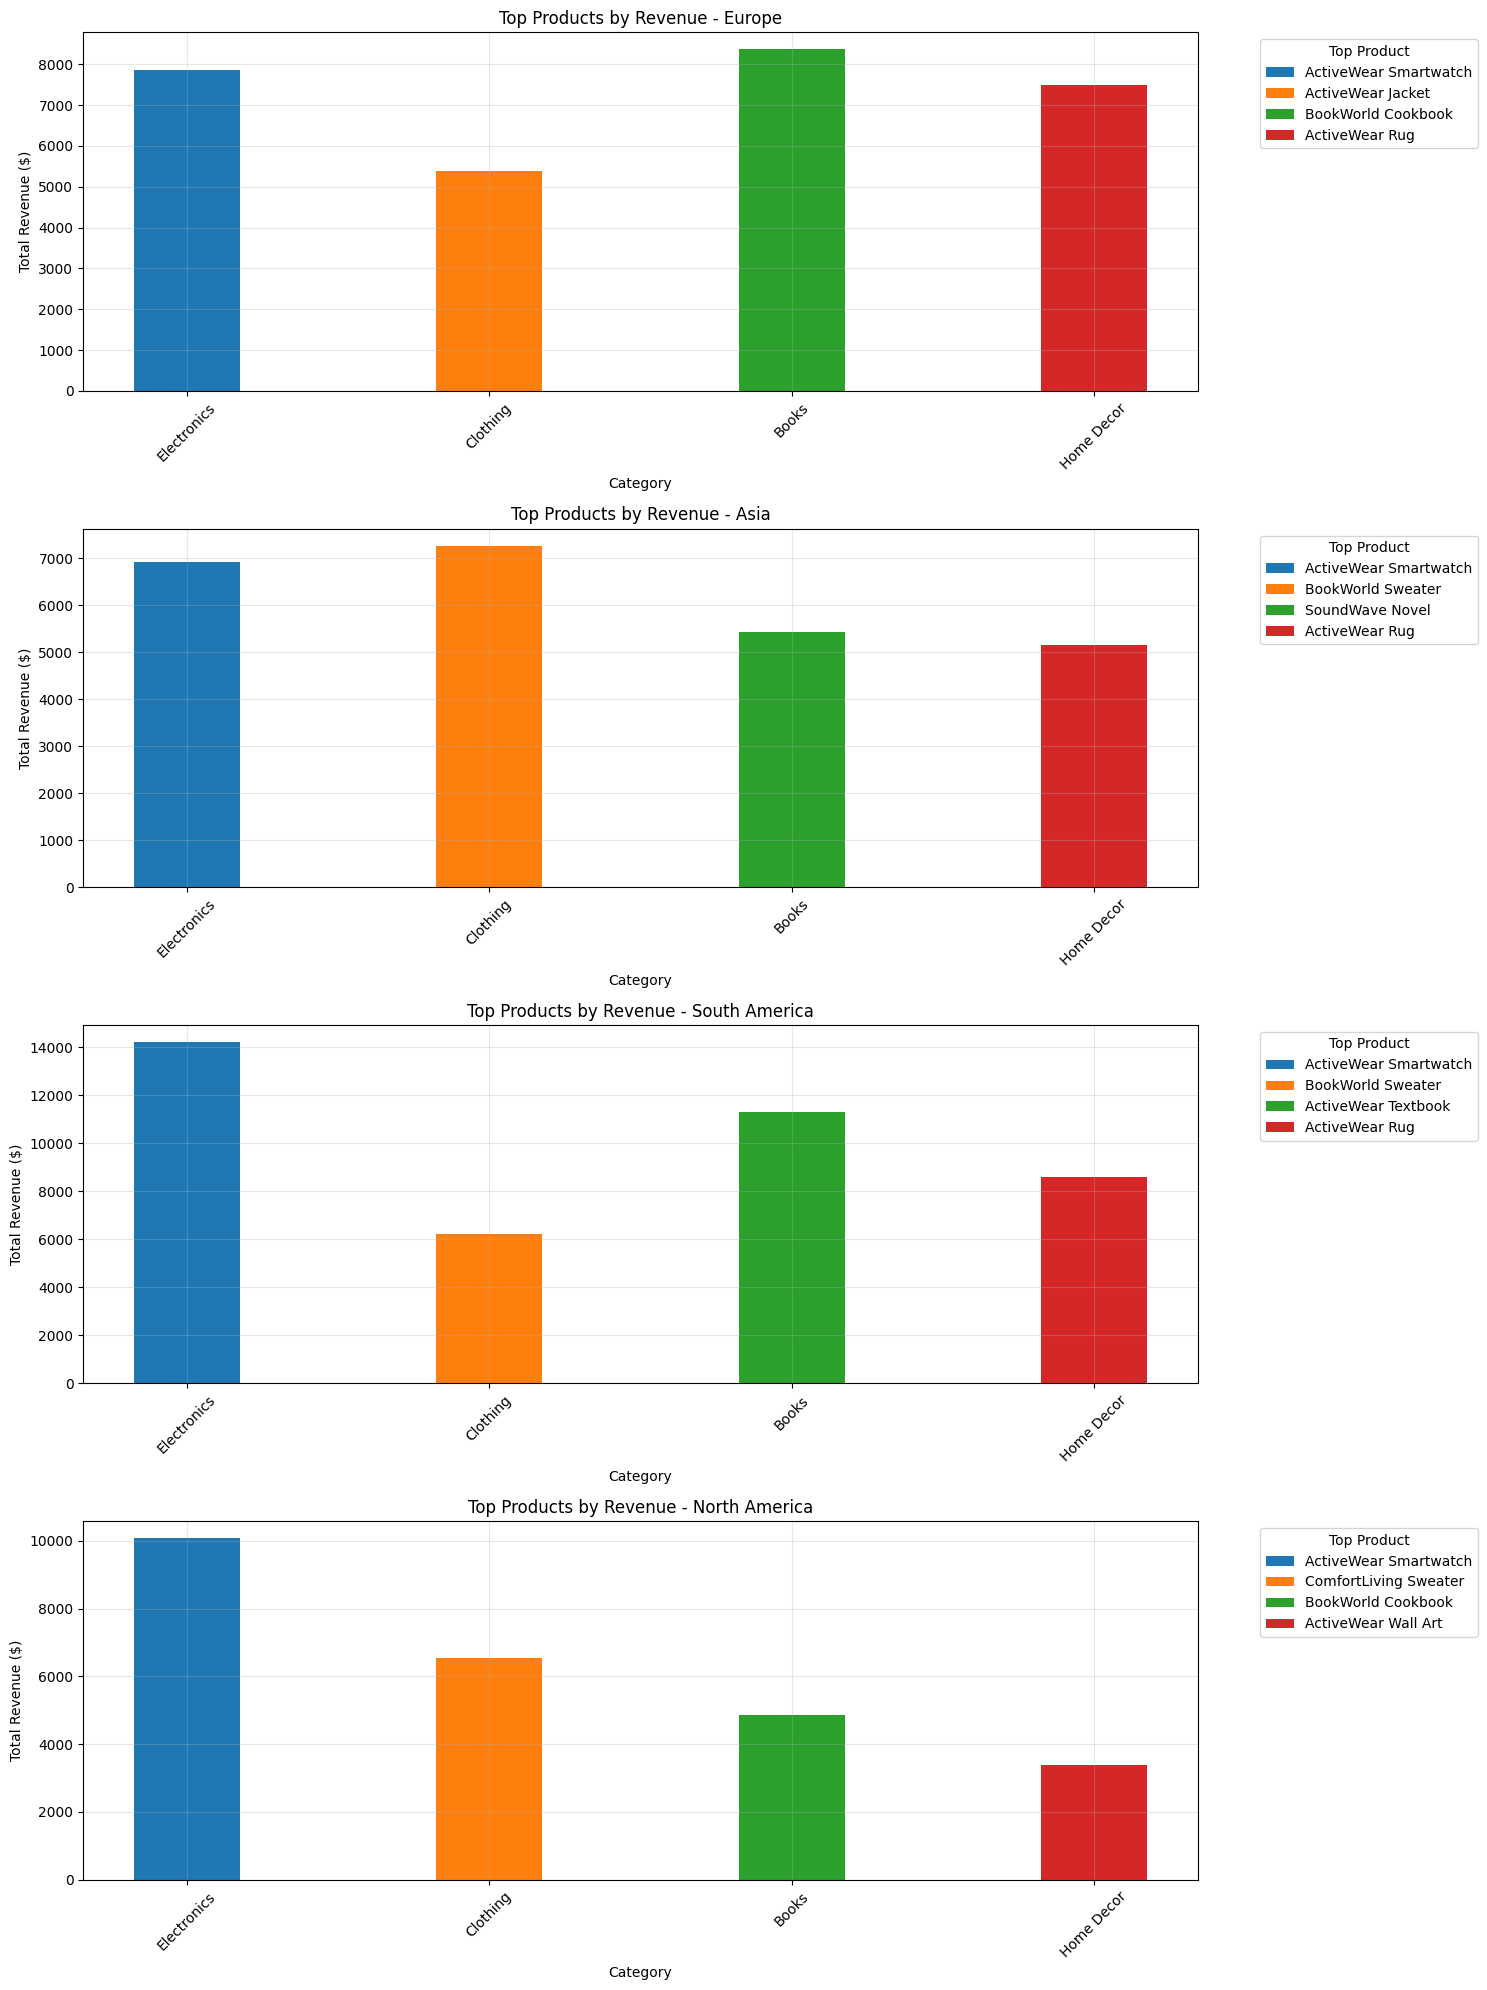

In [26]:
def load_and_validate_data():
    customers = pd.read_csv('data/Customers.csv')
    products = pd.read_csv('data/Products.csv')
    transactions = pd.read_csv('data/Transactions.csv')
    required_columns = {
        'customers': ['CustomerID', 'Region'],
        'products': ['ProductID', 'ProductName', 'Category'],
        'transactions': ['TransactionID', 'CustomerID', 'ProductID', 'Quantity', 'TotalValue']
    }

    for df_name, columns in required_columns.items():
        df = locals()[df_name]
        missing_cols = [col for col in columns if col not in df.columns]
        if missing_cols:
            raise KeyError(f"Missing columns in {df_name}: {missing_cols}")

    df = transactions.merge(customers, on='CustomerID', how='left')\
                    .merge(products, on='ProductID', how='left')

    key_columns = ['Region', 'Category', 'ProductName', 'Quantity', 'TotalValue']
    null_counts = df[key_columns].isnull().sum()
    if null_counts.any():
        df['Region'] = df['Region'].fillna('Unknown Region')
        df['Category'] = df['Category'].fillna('Uncategorized')
        df['ProductName'] = df['ProductName'].fillna('Unknown Product')
        df['Quantity'] = df['Quantity'].fillna(0)
        df['TotalValue'] = df['TotalValue'].fillna(0)

    return df

def analyze_top_products(df):
    product_performance = df.groupby(['Region', 'Category', 'ProductName'], observed=True).agg({
        'Quantity': 'sum',
        'TotalValue': 'sum',
        'TransactionID': 'count'
    }).reset_index()

    top_by_quantity = [
        product_performance[(product_performance['Region'] == region) &
                            (product_performance['Category'] == category)].nlargest(5, 'Quantity')
        for region in df['Region'].unique()
        for category in df['Category'].unique()
    ]

    top_by_quantity = pd.concat(top_by_quantity, ignore_index=True)

    top_by_revenue = [
        product_performance[(product_performance['Region'] == region) &
                            (product_performance['Category'] == category)].nlargest(5, 'TotalValue')
        for region in df['Region'].unique()
        for category in df['Category'].unique()
    ]

    top_by_revenue = pd.concat(top_by_revenue, ignore_index=True)

    return product_performance, top_by_quantity, top_by_revenue

def create_visualizations(df, product_performance, top_by_quantity, top_by_revenue):
    regions = df['Region'].unique()
    categories = df['Category'].unique()

    fig1, axes = plt.subplots(len(regions), 1, figsize=(15, 5 * len(regions)))
    axes = [axes] if len(regions) == 1 else axes

    for idx, region in enumerate(regions):
        region_data = top_by_quantity[top_by_quantity['Region'] == region]
        x = np.arange(len(categories))
        width = 0.35

        for i, category in enumerate(categories):
            cat_data = region_data[region_data['Category'] == category]
            if not cat_data.empty:
                axes[idx].bar(x[i], cat_data['Quantity'].iloc[0], width, label=cat_data['ProductName'].iloc[0])

        axes[idx].set_title(f'Top Products by Quantity - {region}')
        axes[idx].set_xlabel('Category')
        axes[idx].set_ylabel('Quantity Sold')
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(categories, rotation=45)
        axes[idx].legend(title='Top Product', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()

    fig2, axes = plt.subplots(len(regions), 1, figsize=(15, 5 * len(regions)))
    axes = [axes] if len(regions) == 1 else axes

    for idx, region in enumerate(regions):
        region_data = top_by_revenue[top_by_revenue['Region'] == region]
        x = np.arange(len(categories))
        width = 0.35

        for i, category in enumerate(categories):
            cat_data = region_data[region_data['Category'] == category]
            if not cat_data.empty:
                axes[idx].bar(x[i], cat_data['TotalValue'].iloc[0], width, label=cat_data['ProductName'].iloc[0])

        axes[idx].set_title(f'Top Products by Revenue - {region}')
        axes[idx].set_xlabel('Category')
        axes[idx].set_ylabel('Total Revenue ($)')
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(categories, rotation=45)
        axes[idx].legend(title='Top Product', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()

    return fig1, fig2

def calculate_insights(df, product_performance):
    insights = {
        'Top Overall Products': product_performance.nlargest(5, 'Quantity')[
            ['ProductName', 'Category', 'Quantity', 'TotalValue']
        ].to_dict('records'),
        'Category Leaders': {},
        'Regional Winners': {}
    }

    for category in df['Category'].unique():
        category_data = product_performance[product_performance['Category'] == category]
        if not category_data.empty:
            top_product = category_data.nlargest(1, 'Quantity').iloc[0]
            insights['Category Leaders'][category] = {
                'ProductName': top_product['ProductName'],
                'Quantity': top_product['Quantity'],
                'TotalValue': top_product['TotalValue']
            }

    for region in df['Region'].unique():
        region_data = product_performance[product_performance['Region'] == region]
        if not region_data.empty:
            top_product = region_data.nlargest(1, 'Quantity').iloc[0]
            insights['Regional Winners'][region] = {
                'ProductName': top_product['ProductName'],
                'Category': top_product['Category'],
                'Quantity': top_product['Quantity'],
                'TotalValue': top_product['TotalValue']
            }

    return insights

def main():
    df = load_and_validate_data()
    product_performance, top_by_quantity, top_by_revenue = analyze_top_products(df)
    fig1, fig2 = create_visualizations(df, product_performance, top_by_quantity, top_by_revenue)
    insights = calculate_insights(df, product_performance)

    print("\nKey Product Performance Insights:")
    print("\n1. Top 5 Products Overall (by Quantity):")
    for idx, product in enumerate(insights['Top Overall Products'], 1):
        print(f"{idx}. {product['ProductName']} ({product['Category']})")
        print(f"   Quantity: {product['Quantity']}, Revenue: ${product['TotalValue']:,.2f}")

    print("\n2. Category Leaders:")
    for category, data in insights['Category Leaders'].items():
        print(f"\n{category}:")
        print(f"Top Product: {data['ProductName']}")
        print(f"Quantity Sold: {data['Quantity']}")
        print(f"Revenue Generated: ${data['TotalValue']:,.2f}")

    print("\n3. Regional Winners:")
    for region, data in insights['Regional Winners'].items():
        print(f"\n{region}:")
        print(f"Top Product: {data['ProductName']} ({data['Category']})")
        print(f"Quantity Sold: {data['Quantity']}")
        print(f"Revenue Generated: ${data['TotalValue']:,.2f}")

if __name__ == "__main__":
    main()


<h3>Insight 5 - Frequent v/s Occasional Buyers</h3>

C:\Users\rajuk\AppData\Local\Temp\ipykernel_1212\317518187.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_spend = customer_metrics.groupby('Segment')['TotalSpend'].mean()
C:\Users\rajuk\AppData\Local\Temp\ipykernel_1212\317518187.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'segment_stats': customer_metrics.groupby('Segment').agg({
C:\Users\rajuk\AppData\Local\Temp\ipykernel_1212\317518187.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the f


Customer Purchase Frequency Analysis:

Total Customers: 199

Segment Statistics:

Scarce Buyers:
Count: 67.0
Average Transactions: 4.0
Average Total Spend: $2,757.52
Average Purchase Frequency: 0.44 purchases/month
Average Days Between Purchases: 72.3 days

Regular Buyers:
Count: 65.0
Average Transactions: 5.5
Average Total Spend: $3,865.77
Average Purchase Frequency: 0.68 purchases/month
Average Days Between Purchases: 44.8 days

Frequent Buyers:
Count: 67.0
Average Transactions: 5.6
Average Total Spend: $3,790.54
Average Purchase Frequency: 6.47 purchases/month
Average Days Between Purchases: 23.3 days

Purchase Frequency Percentiles (purchases/month):
mean: 2.55
min: 0.20
25%: 0.49
50%: 0.68
75%: 0.92
90%: 1.43
95%: 30.00
max: 30.00

Total Spend by Segment:
Scarce: $184,753.95
Regular: $251,275.31
Frequent: $253,966.30


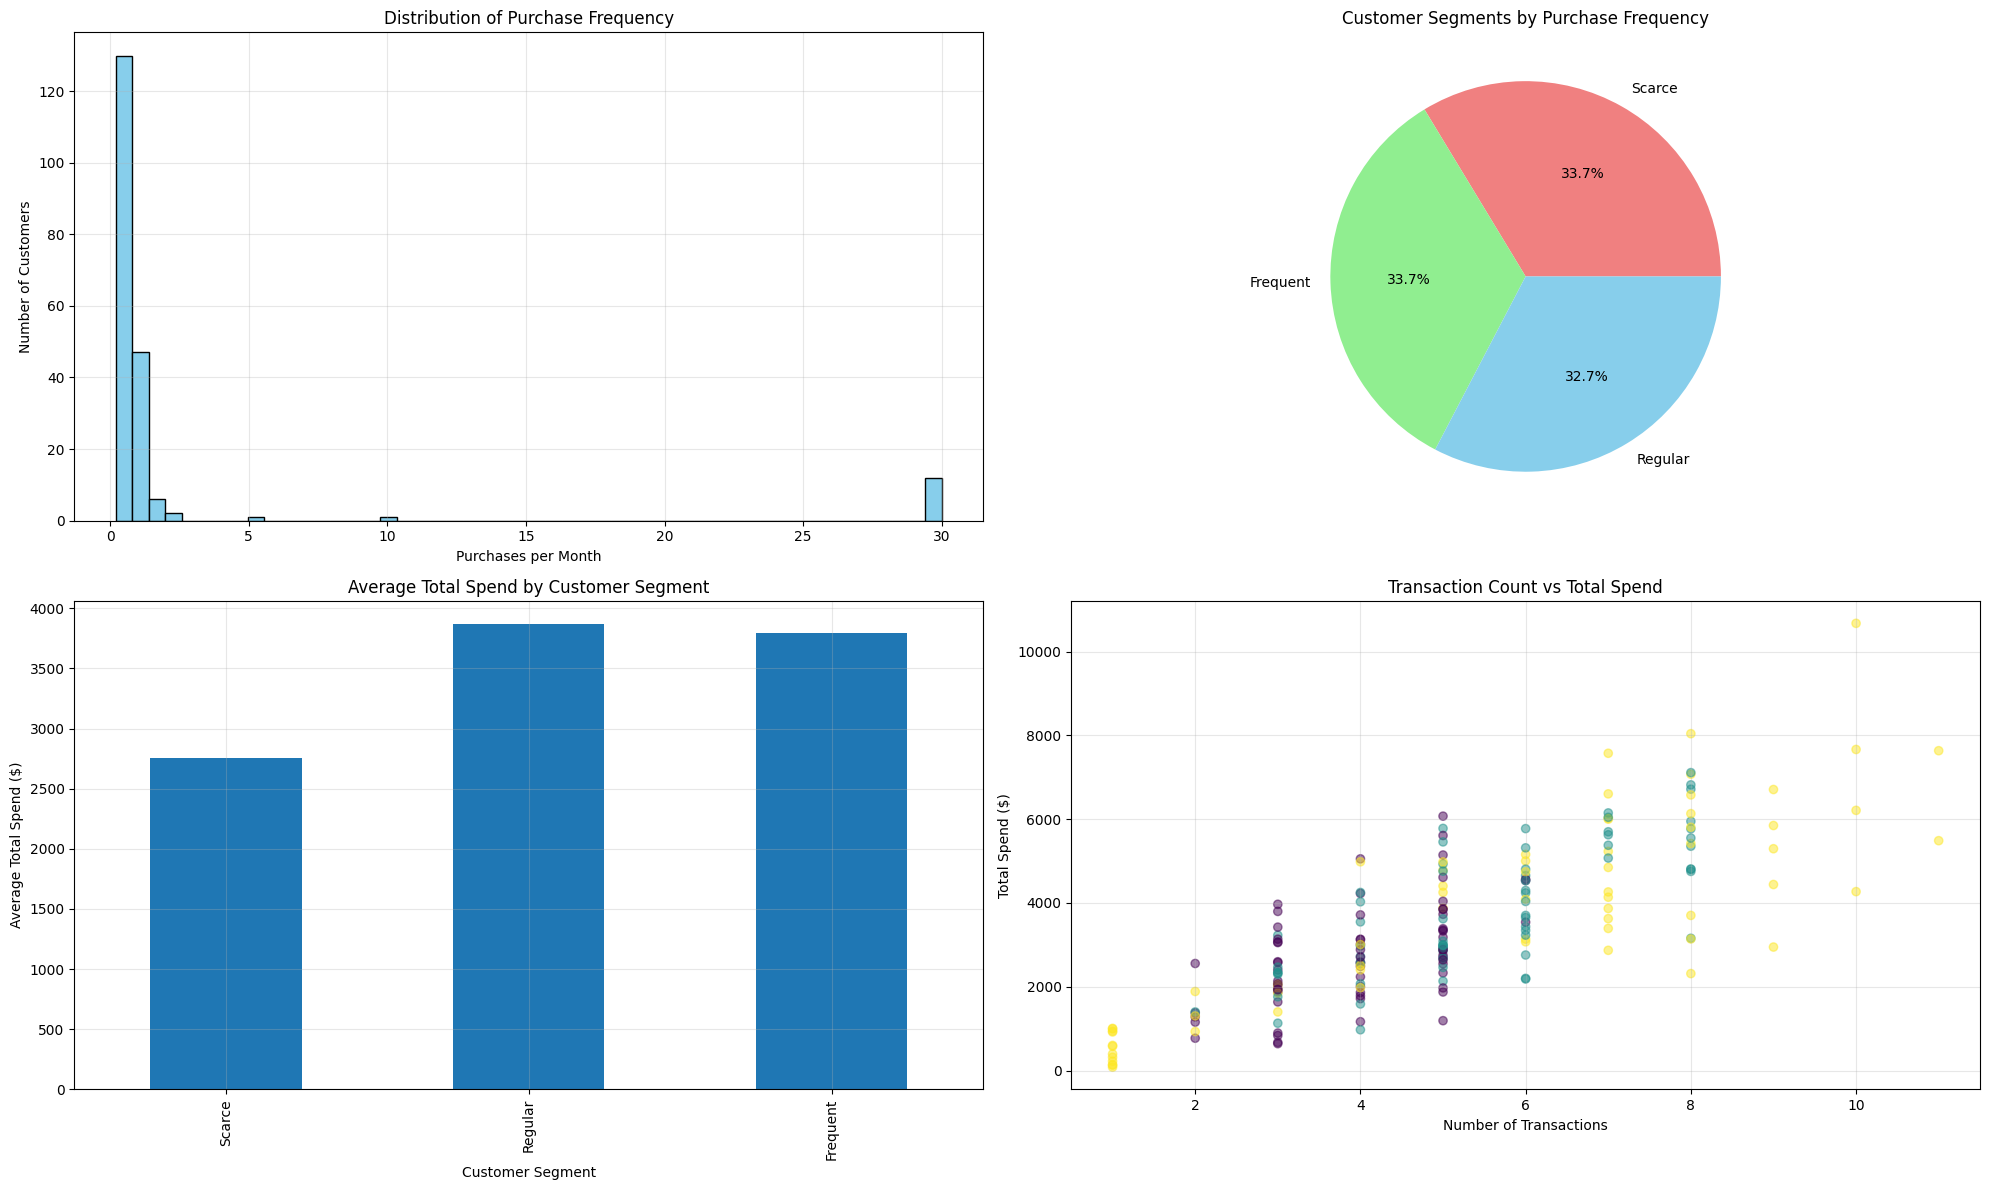

In [27]:
def load_and_validate_data():
    try:
        customers = pd.read_csv('data/Customers.csv')
        transactions = pd.read_csv('data/Transactions.csv')
        required_columns = {
            'customers': ['CustomerID', 'Region'],
            'transactions': ['TransactionID', 'CustomerID', 'TransactionDate', 'TotalValue']
        }
        
        for df_name, columns in required_columns.items():
            df = locals()[df_name]
            missing_cols = [col for col in columns if col not in df.columns]
            if missing_cols:
                raise KeyError(f"Missing columns in {df_name}: {missing_cols}")
        
        df = transactions.merge(customers, on='CustomerID', how='left')
        
        df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
        
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def analyze_purchase_frequency(df):
    if df is None:
        return None
    
    try:
        customer_metrics = df.groupby('CustomerID').agg({
            'TransactionID': 'count',  # Number of transactions
            'TotalValue': 'sum',      # Total spend
            'TransactionDate': lambda x: (x.max() - x.min()).days + 1  # Active period
        }).reset_index()
        
        customer_metrics.columns = ['CustomerID', 'TransactionCount', 'TotalSpend', 'ActiveDays']
        
        customer_metrics['AvgDaysBetweenPurchases'] = customer_metrics['ActiveDays'] / customer_metrics['TransactionCount']
        
        customer_metrics['PurchaseFrequency'] = (customer_metrics['TransactionCount'] / 
                                               (customer_metrics['ActiveDays'] / 30))
        
        customer_metrics['Segment'] = pd.qcut(customer_metrics['PurchaseFrequency'], 
                                            q=3, 
                                            labels=['Scarce', 'Regular', 'Frequent'])
        
        return customer_metrics
    except Exception as e:
        print(f"Error analyzing purchase frequency: {e}")
        return None

def create_visualizations(customer_metrics):
    if customer_metrics is None:
        return None
    
    try:
        fig = plt.figure(figsize=(20, 12))
        
        ax1 = plt.subplot(221)
        plt.hist(customer_metrics['PurchaseFrequency'], bins=50, color='skyblue', edgecolor='black')
        plt.title('Distribution of Purchase Frequency')
        plt.xlabel('Purchases per Month')
        plt.ylabel('Number of Customers')
        plt.grid(True, alpha=0.3)
        
        ax2 = plt.subplot(222)
        segment_counts = customer_metrics['Segment'].value_counts()
        plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%',
                colors=['lightcoral', 'lightgreen', 'skyblue'])
        plt.title('Customer Segments by Purchase Frequency')
        
        ax3 = plt.subplot(223)
        avg_spend = customer_metrics.groupby('Segment')['TotalSpend'].mean()
        avg_spend.plot(kind='bar')
        plt.title('Average Total Spend by Customer Segment')
        plt.xlabel('Customer Segment')
        plt.ylabel('Average Total Spend ($)')
        plt.grid(True, alpha=0.3)
        
        ax4 = plt.subplot(224)
        plt.scatter(customer_metrics['TransactionCount'], 
                   customer_metrics['TotalSpend'],
                   alpha=0.5, c=customer_metrics['Segment'].astype('category').cat.codes)
        plt.title('Transaction Count vs Total Spend')
        plt.xlabel('Number of Transactions')
        plt.ylabel('Total Spend ($)')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    except Exception as e:
        print(f"Error creating visualizations: {e}")
        return None

def calculate_insights(customer_metrics):
    if customer_metrics is None:
        return None
    
    try:
        insights = {
            'segment_stats': customer_metrics.groupby('Segment').agg({
                'CustomerID': 'count',
                'TransactionCount': ['mean', 'median'],
                'TotalSpend': ['mean', 'median'],
                'AvgDaysBetweenPurchases': ['mean', 'median'],
                'PurchaseFrequency': ['mean', 'median']
            }),
            
            'total_customers': len(customer_metrics),
            
            'frequency_percentiles': customer_metrics['PurchaseFrequency'].describe(
                percentiles=[.25, .5, .75, .9, .95]
            ),
            
            'spend_by_segment': customer_metrics.groupby('Segment')['TotalSpend'].sum()
        }
        return insights
    except Exception as e:
        print(f"Error calculating insights: {e}")
        return None

def main():
    df = load_and_validate_data()
    customer_metrics = analyze_purchase_frequency(df)
    if customer_metrics is None:
        return

    fig = create_visualizations(customer_metrics)
    insights = calculate_insights(customer_metrics)
    if insights is None:
        return
    
    print("\nCustomer Purchase Frequency Analysis:")
    print(f"\nTotal Customers: {insights['total_customers']}")
    
    print("\nSegment Statistics:")
    for segment in ['Scarce', 'Regular', 'Frequent']:
        stats = insights['segment_stats'].xs(segment)
        print(f"\n{segment} Buyers:")
        print(f"Count: {stats['CustomerID']['count']}")
        print(f"Average Transactions: {stats['TransactionCount']['mean']:.1f}")
        print(f"Average Total Spend: ${stats['TotalSpend']['mean']:,.2f}")
        print(f"Average Purchase Frequency: {stats['PurchaseFrequency']['mean']:.2f} purchases/month")
        print(f"Average Days Between Purchases: {stats['AvgDaysBetweenPurchases']['mean']:.1f} days")
    
    print("\nPurchase Frequency Percentiles (purchases/month):")
    for percentile, value in insights['frequency_percentiles'].items():
        if percentile not in ['count', 'std']:
            print(f"{percentile}: {value:.2f}")
    
    print("\nTotal Spend by Segment:")
    for segment, spend in insights['spend_by_segment'].items():
        print(f"{segment}: ${spend:,.2f}")

if __name__ == "__main__":
    main()